# Example notebook that performs an EoF analysis of IMOS SRS SST and Chl-a data

In [1]:
import sys
sys.path.append('/home/jovyan/intake-aodn')
import intake_aodn
import intake

In [2]:
import xarray as xr
import dask.array as da
import numpy as np
import dask

In [ ]:
import hvplot.xarray
import geoviews as gv
import panel as pn
from cartopy import crs as ccrs
gv.extension('bokeh')

## 1. Start a dask cluster that adapts to workload

In [ ]:
from intake_aodn.utils import get_distributed_cluster
client = get_distributed_cluster(worker_cores=4,
                                 worker_memory=16,
                                 min_workers=1,
                                 max_workers=32)
client

In [5]:
import fiona # A library for lots of geospatial analysis
import geopandas as gpd # A library for opening shapefiles (and the like) and displaying their attribues and geometry
import matplotlib.pyplot as plt # A general purpose plotting library
import cartopy.crs as ccrs # Library for plotting maps in python
import cartopy.feature as cf # Library for plotting maps in python

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #adds support for reading KML to geopandas
gdf = gpd.read_file('SharkBay.kml', driver='KML')
gdf

,Name,Description,geometry
0,SharkBay,,"POLYGON Z ((113.61460 -24.56049 0.00000, 113.4..."


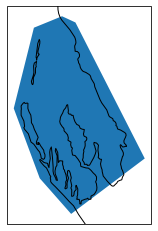

In [6]:
ax = plt.axes(projection = ccrs.PlateCarree())
gdf.plot(ax=ax)
ax.add_feature(cf.COASTLINE)

## 2. Use the Ocean Observer Intake Catalogs to open datasets directly from S3

In [7]:
cat = intake_aodn.cat

In [8]:
darrays = {}

In [10]:
darrays['sst'] = cat.aodn_s3.SST_L3S_1d_ngt(startdt='2003-01-01',
                                 enddt='2021-06-30',
                                 geom=str(gdf.geometry[0])).to_dask()['sea_surface_temperature']-273.

In [11]:
darrays['chla'] = np.log(cat.aodn_s3.MODIS_1d_chl_oc3(startdt='2003-01-01',
                                 enddt='2021-06-30',
                                 geom=str(gdf.geometry[0])).to_dask()['chl_oc3'])

In [12]:
# darrays['k490'] = cat.aodn_s3.MODIS_1d_K_490(startdt='2003-01-01',
#                                  enddt='2021-01-01',
#                                  geom=str(gdf.geometry[0])).to_dask()['K_490']

In [13]:
darrays

{'sst': <xarray.DataArray 'sea_surface_temperature' (time: 6647, latitude: 114, longitude: 84)>
 dask.array<sub, shape=(6647, 114, 84), dtype=float32, chunksize=(3500, 114, 84), chunktype=numpy.ndarray>
 Coordinates:
   * latitude   (latitude) float32 -24.49 -24.51 -24.53 ... -26.71 -26.73 -26.75
   * longitude  (longitude) float32 112.8 112.8 112.9 112.9 ... 114.4 114.5 114.5
   * time       (time) datetime64[ns] 2003-01-01T15:20:00 ... 2021-06-27T15:20:00,
 'chla': <xarray.DataArray 'chl_oc3' (time: 6638, latitude: 228, longitude: 168)>
 dask.array<log, shape=(6638, 228, 168), dtype=float32, chunksize=(868, 228, 168), chunktype=numpy.ndarray>
 Coordinates:
   * latitude   (latitude) float64 -24.49 -24.5 -24.51 ... -26.74 -26.75 -26.76
   * longitude  (longitude) float64 112.8 112.8 112.8 112.9 ... 114.5 114.5 114.5
   * time       (time) datetime64[ns] 2003-01-01T05:30:00 ... 2021-06-29T05:30:00
 Attributes:
     flag_applied:  HISATZEN LAND CLDICE NAVFAIL
     long_name:     Chlorop

## 3. Calculate monthly means for each dataset to reduce cloud influences, reindex onto a consistent grid and stack lon and lat into a space dimension

In [ ]:
monthly_means = {k:da.resample(time='1m').mean().persist() for k,da in darrays.items()} #.stack(space=['latitude','longitude'])

monthly_stacked = {k:da.reindex_like(monthly_means['sst'],method='nearest').stack(space=['latitude','longitude']).dropna(dim='space') for k,da in monthly_means.items()} 

monthly_stacked

## 4. Normalise the datasets and assign a coordinate to each array (sst,chla) and concatenate
The coordinate is automatically broadcast across the space dimension, allowing retrieval of the different fields from the modes after SVD

In [17]:
time_mean = {k:da.mean(dim='time') for k,da in monthly_stacked.items()}
time_std = {k:da.std(dim='time') for k,da in monthly_stacked.items()}
monthly_normalised = {k:(da-time_mean[k])/time_std[k].assign_coords({'var':k}) for k,da in monthly_stacked.items()}
da_concat = xr.concat(monthly_normalised.values(),dim='space').rename('sst_chla')
da_concat

<xarray.DataArray 'sst_chla' (time: 222, space: 9300)>
dask.array<concatenate, shape=(222, 9300), dtype=float32, chunksize=(1, 4816), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2003-01-31 2003-02-28 ... 2021-06-30
  * space      (space) MultiIndex
  - latitude   (space) float64 -24.49 -24.49 -24.49 ... -26.75 -26.75 -26.75
  - longitude  (space) float64 112.8 112.8 112.9 112.9 ... 113.6 113.6 113.6
    var        (space) <U4 'sst' 'sst' 'sst' 'sst' ... 'chla' 'chla' 'chla'

## 5. Remove any missing data along the time dimension and perform SVD

In [18]:
da_svd_data = da_concat.dropna(dim='time').chunk({'time':50,'space':-1})

u, s, v = da.linalg.svd_compressed(da_svd_data.data,k=10) #Only approximate the first 10 modes

ds_svd = da_svd_data.to_dataset()
ds_svd.coords['mode']=np.arange(len(s))
ds_svd['u']=(('time','mode'),u)
ds_svd['s']=(('mode',),s/s.sum())
ds_svd['v']=(('mode','space'),v)
ds_svd

<xarray.Dataset>
Dimensions:    (time: 222, space: 9300, mode: 10)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-31 2003-02-28 ... 2021-06-30
  * space      (space) MultiIndex
  - latitude   (space) float64 -24.49 -24.49 -24.49 ... -26.75 -26.75 -26.75
  - longitude  (space) float64 112.8 112.8 112.9 112.9 ... 113.6 113.6 113.6
    var        (space) <U4 dask.array<chunksize=(9300,), meta=np.ndarray>
  * mode       (mode) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    sst_chla   (time, space) float32 dask.array<chunksize=(50, 9300), meta=np.ndarray>
    u          (time, mode) float32 dask.array<chunksize=(50, 10), meta=np.ndarray>
    s          (mode) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    v          (mode, space) float32 dask.array<chunksize=(10, 9300), meta=np.ndarray>

## 6. The data is small so return to the notebook using .load and shutdown the cluster 

In [19]:
print(f'{ds_svd.nbytes/1E9:.3f} GB')

0.009 GB


In [20]:
ds_svd = ds_svd.load()
monthly_means = {k:da.load() for k,da in monthly_means.items()}
ds_svd

<xarray.Dataset>
Dimensions:    (time: 222, space: 9300, mode: 10)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-31 2003-02-28 ... 2021-06-30
  * space      (space) MultiIndex
  - latitude   (space) float64 -24.49 -24.49 -24.49 ... -26.75 -26.75 -26.75
  - longitude  (space) float64 112.8 112.8 112.9 112.9 ... 113.6 113.6 113.6
    var        (space) <U4 'sst' 'sst' 'sst' 'sst' ... 'chla' 'chla' 'chla'
  * mode       (mode) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    sst_chla   (time, space) float32 0.00309 0.04355 0.05442 ... -0.3914 -0.4397
    u          (time, mode) float32 0.009572 -0.08911 ... -0.05704 0.007515
    s          (mode) float32 0.3282 0.2029 0.122 ... 0.03658 0.03231 0.02921
    v          (mode, space) float32 0.0131 0.01313 ... -0.01472 -0.009198

In [23]:
# Select each field and unstack into 2D
dsets_modes = {k:ds_svd.isel(space=(ds_svd['var']==k)).unstack('space') for k in darrays.keys()}
dsets_modes

{'sst': <xarray.Dataset>
 Dimensions:    (time: 222, latitude: 114, longitude: 71, mode: 10)
 Coordinates:
   * time       (time) datetime64[ns] 2003-01-31 2003-02-28 ... 2021-06-30
     var        (latitude, longitude) object 'sst' 'sst' 'sst' ... nan nan nan
   * mode       (mode) int64 0 1 2 3 4 5 6 7 8 9
   * latitude   (latitude) float64 -26.75 -26.73 -26.71 ... -24.53 -24.51 -24.49
   * longitude  (longitude) float64 112.8 112.8 112.9 112.9 ... 114.2 114.2 114.2
 Data variables:
     sst_chla   (time, latitude, longitude) float32 0.0105 0.01088 ... nan nan
     u          (time, mode) float32 0.009572 -0.08911 ... -0.05704 0.007515
     s          (mode) float32 0.3282 0.2029 0.122 ... 0.03658 0.03231 0.02921
     v          (mode, latitude, longitude) float32 0.01286 0.01283 ... nan nan,
 'chla': <xarray.Dataset>
 Dimensions:    (time: 222, latitude: 114, longitude: 71, mode: 10)
 Coordinates:
   * time       (time) datetime64[ns] 2003-01-31 2003-02-28 ... 2021-06-30
     var   

In [21]:
client.cluster.shutdown()

## 7. Naval gaze at some plots

In [ ]:
# Explained variance
dsets_modes['sst']['s'].hvplot()

In [ ]:
pcas = dsets_modes['sst']['u'].isel(mode=slice(0,3)).hvplot(by='mode',width=1200)

modes = gv.Layout([ds['v'].hvplot('longitude',
                                  'latitude',
                                  groupby='mode',
                                  label=k,
                                  cmap='RdBu_r',
                                  width=400,
                                  height=400).redim(v=dict(range=(-0.02, 0.02))) for k,ds in dsets_modes.items()])

monthly = gv.Layout([da.hvplot('longitude',
                               'latitude',
                               groupby='time',
                               label=k,
                               width=400,
                               cmap='RdBu_r',
                               height=400).redim(sea_surface_temperature=dict(range=(20, 30)),chl_oc3=dict(range=(-2, 4))) for k,da in monthly_means.items()])

# Compose togther in a panel
pcas = pn.panel(pcas)
modes = pn.panel(modes)
monthly = pn.panel(monthly)
layout = pn.Column(pcas,modes,monthly)
layout